---
**Chapter 08**
# **Introduction to deep learning for computer vision**
---


In [2]:
# System Libraries
import importlib, sys, os
import numpy as np

# TensorFlow Libraries
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
from tensorflow import keras
import tensorflow as tf

# User Libraries
sys.path.append("../")
from modules import common, chapter_01, chapter_08

# Reload Libraries
importlib.reload(chapter_01)
importlib.reload(chapter_08)
importlib.reload(common)

# Check GPU
print(tf.config.list_physical_devices())

# Module variables
batch_size = 512
epochs = 10

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
# **Convolution theory**
---


### <ins />**Convolution layers**
  - Dense layers learn patterns of global input feature map (thus not used in object detection)
  - Conv layers learn patterns of local input patch
  - Convolution classification network has two parts:
     - Convolution base: Conv2D + Maxpooling
     - Logit: Dense
  - Convolution base:
    - Lower layers extract specific feature maps
    - Upper layers extract highly generic feature maps
  - Spatial hierarchical patterns
    - Upper layers learn generic patterns
    - Lower layers learn specific patterns
  - Translation invariant patterns
    - After learning a pattern once, conv layer can infer it anywhere in the image
  - Dense layer is also called fully connected layer

### <ins />**Feature map**
  - Height, Width, Channels (H, W, D)
  - Feature map size: HxW
  - Feature map depth: D
  - For larger images, we increase number of layers:
    - To increase feature map depth
    - To decrease feature map size
    - To increase model capacity
  - In a convnet
    - Feature map depth increases with each layer
    - Feature map size decreases with each layer
  
### <ins />**Input feature map (3D)**
  - 28x28x1 matrix input image

### <ins />**Filter**
  - Depth of output feature map
  - 32, 64, etc.

### <ins />**Kernel (2D)**
  - 3x3 matrix aka convolution kernel / structuring element
  - Same kernel is used with all input patches

### <ins />**Input patch (2D)**
  - 3x3 matrix patch of input feature map

### <ins />**Response map (1D)**
  - 3x1 tensorproduct of kernel and input patch

### <ins />**Output feature map (3D)**
  - Combine all response maps into matrix
  
### <ins />**Convolution operation (sliding window)**
  1. Slide the kernel on input feature map
  2. Extract input patch
  3. Tensor product the kernel and input patch to get response map vector
  4. Combine all response map vectors (one per patch) to get output feature map
  5. Output map size is less than input map size due to convolution border effect and stride

### <ins />**Padding**
  - To counter border effect i.e. in order to have output map size equals input map size
  - Valid padding
    - No padding applied (default)
    - Output map size < Input map size
  - Same padding
    - Padding applied
    - Output map size = Input map size
    - Padding size depends on kernel size, not on input patch size
    - Padding for 3x3 kernel:
      - 1 row on top. 1 row on bottom
      - 1 column on right. 1 column on left
    - Padding for 5x5 kernel:
      - 2 rows on top. 2 rows on bottom
      - 2 columns on right. 2 columns on left

### <ins />**Stride**
  - <ins />**Used when spatial location information is important (segmentation, detection)**
  - Distance between two consecutive convolution windows
  - Downsampling mechanism
  - Stride=1 (default)

### <ins />**Maxpooling**
  - <ins />**Used when spatial location information is not important (classification)**
  - Max patch: 2x2 matrix of max value of input patch (no information of location)
  - Output: Tensorproduct of max patch and input patch
  - It  detroys location information
  - Downsampling mechanism

### <ins />**Convolution vs Maxpooling vs Avgpooling**
  - Maxpooling:
    - Kernel=2x2 (pool size)
    - Stride=2
    - **Kernel uses max value of input patch**
    - Feature map size is reduced by **size / 2**
  - Avgpooling:
    - Kernel=2x2 (pool size)
    - Stride=2
    - **Kernel uses average value of input patch**
    - Feature map size is reduced by **size / 2**
  - Convolution:
    - Kernel=3x3 (kernel size)
    - Stride=1
    - **Kernel uses fixed value irrespective of input patch**
    - Feature map size is reduced by **size - 2**

### <ins />**Why downsample (conv, stride, maxpooling, avgpooling)**
  - Reduce number of coefficients and overfit
    - Without maxpooling = 61952 coefficients 
    - With maxpooling = 1152 coefficients  
  - Increase channel-to-height/width ratio
    - Without maxpooling = 24x24x64
    - With maxpooling = 11x11x64

### <ins />**Data augmentation**
   - Remix the already available information
   - No new information created
   - No effect during inference
   - Used along with dropout


### <ins />**Transfer learning**
  - Models trained on large dataset (different classes) serve as generic model of visual world
  - E.g. Model trained on ImageNet (animals) used as base model for bottle detection
  - Deep learning with convet is effective for small dataset due to  transfer learning
  - Types of transfer learning: 
    - Feature extraction
    - Fine tuning

### <ins />**Feature extraction**
  - Take convolution base of another model and add a new fully connected (dense) layer
  - Using dense layer from another model **should be avoided**
  - New dataset has similar classes:
    - Use all layers of convolution base except dense layer
  - New dataset has different classes:
    - Use upper layers of convolution base
  - Types of feature extraction:
    - Conv base not part of training:
      - Use conv base to extract features once before training
      - Feed conv base output to dense classifier during training
      - Conv base is not part of training
      - Augmentation layer not possible
      - Faster
    - Conv base part of training
      - Train end-to-end conv base along with dense classifier
      - Weights of conv base should be frozen
      - Augmentation layer possible
      - Slower

### <ins />**Fine tuning**
  - In fine tuning, only few upper layers are frozen (containing generic information)
  - In feature extractions, all layers are frozen

---
# **Explore maxpooling and padding**
---

### <ins />**Case-1: No padding. No maxpooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

### <ins />**Case-2: With padding. No maxpooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

### <ins />**Case-3: No padding. With maxpooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

### <ins />**Case-4: Model with padding, with maxpooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

---
# **Tensorflow Dataset API**
---

- Efficient input batch pipeline
- Asynchronous data prefetching (fetch new batch while previous batch is being handled by model)
- normal vs uniform distributions?

In [ ]:
dataset = [x for x in range(0, 20)]
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# Shuffle
dataset = dataset.shuffle(len(dataset))
# Batch
dataset = dataset.batch(5)
for batch in dataset:
    print("Original: ", batch)
# Reduce
reduced = dataset.reduce(initial_state=0, reduce_func=lambda x, y: x + y)
print("Reduced: ", reduced)
# Map
dataset = dataset.map(lambda x: x * 0)
for batch in dataset:
    print("Mapped: ", batch)

---
# **Mnist convolution network**
---

### <ins />**Notes**

- Between conv and dense layers, always use flatten and dropout layers
    - Conv2D 
    - Flatten 
    - Dense without activation
    - Dropout 
    - Dense with activation

### <ins />**Dataset**

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

### <ins />**Model**

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Rescaling(1.0 / 255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### <ins />**Train**

In [ ]:
model = chapter_01.compile(model=model)
history = chapter_01.train(x_train, y_train, model, batch_size=batch_size, callbacks=common.callbacks(), epochs=epochs)
chapter_01.evaluate(x_test, y_test, model)
common.plot(data=[history], labels=["00_mnist_convnet"])

---
# **Kaggle cats-vs-dog dataset**
---

### <ins />**Dataset**

In [ ]:
new_base_dir, train_dataset, val_dataset, test_dataset = chapter_08.dataset_batches()

### <ins />**Augmentation**

In [7]:
augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

---
# **Training from scratch without augmentation**
---

### <ins />**Model**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Rescaling(1.0 / 255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### <ins />**Train**

In [ ]:
model_path = "01_train_scratch.keras"
chapter_08.train_batch(train_dataset, val_dataset, test_dataset, model, model_path, epochs, batch_size)

---
# **Training from scratch with augmentation**
---

### <ins />**Model**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = augmentation(inputs)
x = keras.layers.Rescaling(1.0 / 255)(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### <ins />**Train**

In [ ]:
model_path = "02_train_scratch_augmentation.keras"
chapter_08.train_batch(train_dataset, val_dataset, test_dataset, model, model_path, epochs, batch_size)

---
# **Training using feature extraction without augmentation**
---

### <ins />**Convolution base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3),
)
print("Weights: ", len(conv_base.trainable_weights))

### <ins />**Features**

In [ ]:
def extract_features(dataset):
    features, labels = [], []
    for images_batch, labels_batch in dataset:
        images_batch = keras.applications.vgg16.preprocess_input(x=images_batch)
        features_batch = conv_base.predict(x=images_batch, verbose=False)
        features.append(features_batch), labels.append(labels_batch)
    return np.concatenate(features), np.concatenate(labels)


x_train, y_train = extract_features(train_dataset)
x_val, y_val = extract_features(val_dataset)
x_test, y_test = extract_features(test_dataset)

### <ins />**Model**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(units=256, activation=None)(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### <ins />**Train**

In [ ]:
model_path = "03_train_feature_extraction.keras"
chapter_08.train(x_train, y_train, x_val, y_val, x_test, y_test, model, model_path, epochs, batch_size)

---
# **Training using feature extraction with augmentation**
---

### <ins />**Convolution base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
# Freeze all layers (dont overwrite conv base weights)
conv_base.trainable = False
print("Weights: ", len(conv_base.trainable_weights))

### <ins />**Model**

In [5]:
def get_model(conv_base):
    inputs = keras.Input(shape=(180, 180, 3))
    x = augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=256, activation=None)(x)
    x = keras.layers.Dropout(rate=0.5)(x)
    outputs = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = get_model(conv_base)

### <ins />**Train**

In [ ]:
model_path = "04_train_feature_extraction_augmentation.keras"
chapter_08.train_batch(train_dataset, val_dataset, test_dataset, model, model_path, epochs, batch_size)

---
# **Training using fine tuning**
---

### <ins />**Convolution base**

In [3]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
# Freeze all layers except last convolution block (last 4 layers)
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### <ins />**Model**

In [8]:
model = get_model(conv_base)

### <ins />**Train**

In [ ]:
model_path = "05_train_finetuning_augmentation.keras"
chapter_08.train_batch(train_dataset, val_dataset, test_dataset, model, model_path, epochs, batch_size)

### <ins />**Convolution base architecture**

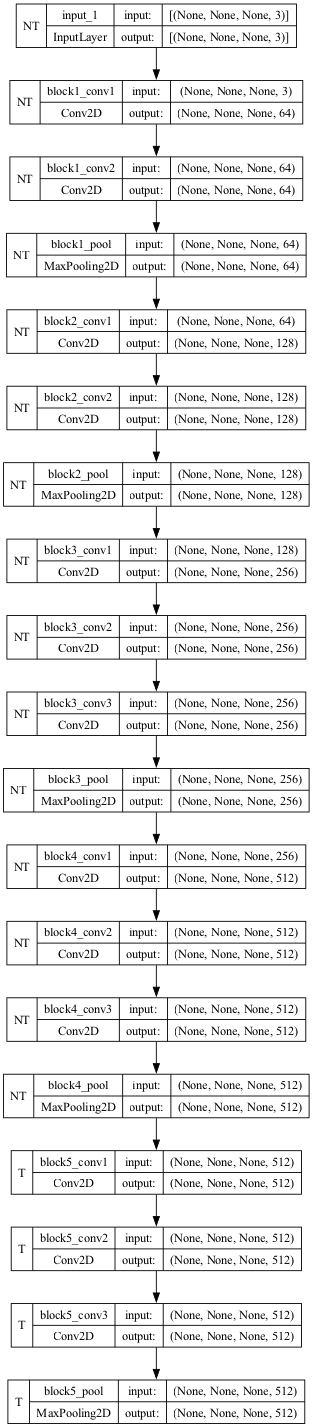

In [11]:
keras.utils.plot_model(
    conv_base,
    "../resources/images/tmp/model.png",
    show_shapes=True,
    show_trainable=True,
    dpi=64,
)